# Compute the minimised free energy for a given correlation matrix
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Content**
Script that takes as input the pruned correlation matrix, f.e. generated from a time series set, and gives as output:
- The subject ID
- The analytical max(S)
- The analytical min(U)
- The optimised min(F) for a range of temperatures (so a list of scalars)
- The probability distribution p for each optimised F (so a list of lists)

Note: if I want to include the pruning of the matrix, I have to give as input the original timeseries from which the correlation matrix and phase randomised can be generated, and then the pruned one consecutively.

In [51]:
# Import necessary libraries
import numpy as np
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import external background functions
%run Week_18_functions.py

In [52]:
# Import HCP data to test the script
path = glob.glob('Pruned_data_HCPAging\REST1\*.txt')

In [60]:
def complete_f_generator(file, cutoff, max_dim):

    # Import datafile as matrix
    matrix = np.loadtxt(file)

    # Extract patient ID from filename
    parts = file.split('_')
    for part in parts:
        if part.startswith("HCA"):
            identification_code = part[3:]
            break

    # Generate connection matrix and inverse
    clique_complex =  build_clique_complex_new(matrix, cutoff, max_dim)
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

    # Generate maximum shannon entropy from uniform distribution
    n = len(inverse_connectivity_matrix)
    p_Smax = np.ones(n) / n
    max_entropy_value = shannon_entropy(p_Smax)

    # Generate minimum internal energy from analytical solution
    min_energy_probabilities = (np.inner(matrix,[1]*len(matrix)))/np.sum(matrix)
    min_energy_value = energy_function(min_energy_probabilities, inverse_connectivity_matrix)

    # Generate minimum free energy by custom optimisation
    f_per_T = []
    p_per_T = []
    temperature_list = np.arange(0, 1, 0.1)

    for temperature in temperature_list:
        free_energy_history, f_probabilities = free_energy_minimisation(clique_complex, inverse_connectivity_matrix, 10, temperature)
        f_per_T.append(free_energy_history[-1])
        p_per_T.append(f_probabilities)
    
    return [identification_code, max_entropy_value, min_energy_value, f_per_T, p_per_T, temperature_list]

In [65]:
F = complete_f_generator(path[0], 0.9, 2)
print(F[2], F[1])

0.008620689655172414 6.857980995127573


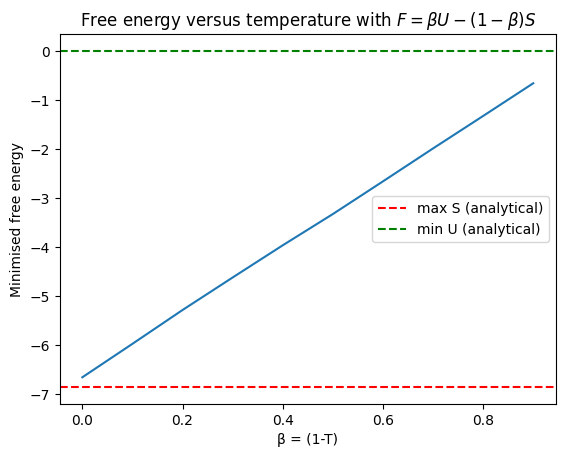

In [75]:
plt.plot(F[5], F[3])
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-F[1], color='r', linestyle='--', label='max S (analytical)')
plt.axhline(y=F[2], color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()